# Vive Position Calibration using 4 Points
With this calibration approach we attempt to use the smallest number of data-points to reduce the number of local optima that can cause our minimization-problem to converge to an incorrect solution. We define a coordinate-system in the room and position a square with sides of known length $d$ in the x-y plane such that: 
 - p1 is at the origin $(0,0,0)$
 - p2 is along the positive y-axis $(0,d,0)$
 - p3 is along the positive x-axis $(d,0,0)$
 - p4 is on the last corner of the square $(d,d,0)$

Record angle-measurement form the base-stations at each of these points and put the information into $a1$, $a2$, $a3$, $a4$ below accordingly. 


## Strategy
The calibration is performed on each base-station separately. The algorithm can be outlined as follows: 
- Convert base-station angles to vector directions.
- Define lines from vector directions that go the same point (the base-station, currently defined to be the origin).
- Search for points on lines 1, 2 and 3 that conform to the known geometric relations between points 1, 2 and 3. 
    - 2 solutions will exits. 
- Perform this for both base-stations and compute position $p4$ using all 4 combinations of base-station positions and the base-station angles $a4$ for this point.
- Choose the base-station positions that make the computed $p4$ closest to $(d,d,0)$.
 
Refer to [Calibration.py](Calibration using 4 Points resources/Calibration.py) for implementation in Python. This implementation has been translated with only minor changes to C++ for use live use on the Teensy module.

## Mathematical foundation
For an outline of the reasoning backing the algorithm, see [this file](Calibration using 4 Points resources/Calibration 4 point line fitting.pdf).


## Algorithm
The following Python script defines the angles and calls the methods in [Calibration.py](Calibration using 4 Points resources/Calibration.py). It also provides a visualization if the solution and of the zero-intercepts we solve to determine the distance from the origin to each point on their respective lines. 

Calibrated Poses:
[[ 1.47121027  1.6169706   2.58055347  2.52181859 -0.38115308  2.0838849 ]
 [-1.35161147 -0.92432517  2.45250703 -2.47324735  0.57558361 -0.89735399]]

p1 = [  0.00000000e+00  -3.88578059e-16   0.00000000e+00]
p2 = [  8.03468403e-13   5.00000000e-01   9.15711951e-13]
p3 = [  5.00000000e-01  -4.44089210e-16  -1.55431223e-15]
p4 = [ 0.50198509  0.49700121  0.00809091]

Distance form p4real to p4computed with calibrated base stations:  0.707878590912


<IPython.core.display.Javascript object>


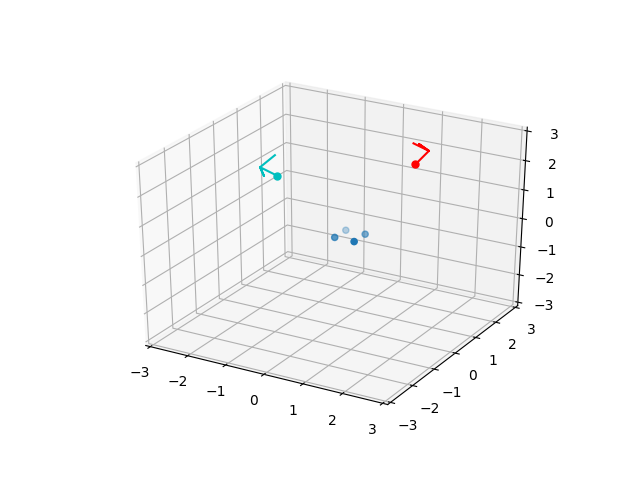

In [1]:
%matplotlib notebook
%run "Calibration using 4 Points resources/Calibration.py"
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

CALIBRATION_SQUARE_SIDE_LENGTH = 0.5

a1 = [0.087123,-0.012976,0.108385,-0.261253]
a2 = [0.186421,-0.109069,-0.018332,-0.179241]
a3 = [-0.034443,-0.085106,0.202967,-0.156475]
a4 = [0.060507,-0.192164,0.080714,-0.086680]

P1, P2 = np.array(baseStationPositions(a1, a2, a3, a4))
P1[0:3] = P1[0:3]*CALIBRATION_SQUARE_SIDE_LENGTH
P2[0:3] = P2[0:3]*CALIBRATION_SQUARE_SIDE_LENGTH

print 'Calibrated Poses:\n', np.array([P1, P2])

p1New = positionFromMeasurement(a1, P1, P2)
p2New = positionFromMeasurement(a2, P1, P2)
p3New = positionFromMeasurement(a3, P1, P2)
p4New = positionFromMeasurement(a4, P1, P2)

print '\np1 =', p1New
print 'p2 =', p2New
print 'p3 =', p3New
print 'p4 =', p4New
print '\nDistance form p4real to p4computed with calibrated base stations: ', norm(np.array([1,1,0]) - np.array(p4New))


## Plot resulting estimate
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

# Poses of LH
plot_axes(ax2,P1,'r')
plot_axes(ax2,P2,'c')
ax2.set_xlim3d(-3,3)
ax2.set_ylim3d(-3,3)
ax2.set_zlim3d(-3,3)

sNew = np.vstack((p1New,p2New,p3New,p4New)).T
ax2.scatter(sNew[0], sNew[1], sNew[2])

## Visualizing Root Choice
If we look at the 4 possible rots of the equations simultaneously, we see that they are each symmetric about t=0 and that they seem to be meet when the second quadratic solution transfers from using the positive to the negative root. We have in essence one continuous loop with x-axis intersection for two discrete positive values of x. These two roots are determined and stored. When the information is present for both, we use point 4 to infer which root-choice is correct for this particular geometry.

<IPython.core.display.Javascript object>


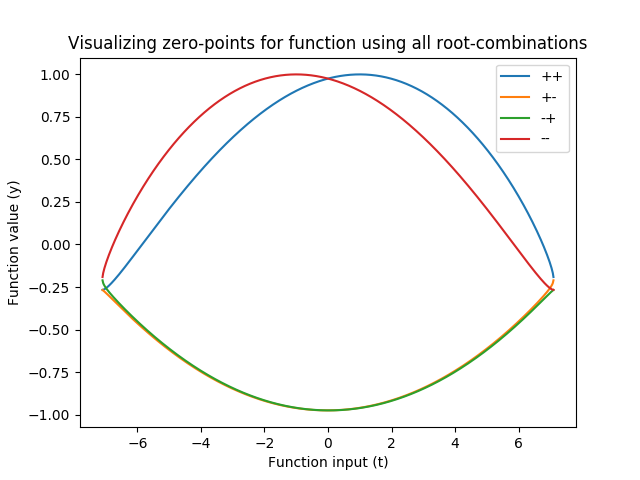

In [2]:
# Visualizing Roots
t = np.linspace(-10,10,1000)

b1 = measuredAnglesToVector(a1[0], a1[1])
b2 = measuredAnglesToVector(a2[0], a2[1])
b3 = measuredAnglesToVector(a3[0], a3[1])

af = ApplicationFunction(b1, b2, b3)

allSolutions = [[af.eq(t1, i/2, i%2) for t1 in t] for i in range(4)]

plt.figure()

for i in range(len(allSolutions)):
    sol = []
    xs = []
    for j in range(len(allSolutions[i])):
        if allSolutions[i][j] != 0:
            sol.append(allSolutions[i][j])
            xs.append(t[j])
    
    plt.plot(xs,sol)
plt.title('Visualizing zero-points for function using all root-combinations')
plt.xlabel('Function input (t)')
plt.ylabel('Function value (y)')
plt.legend(['++', '+-', '-+', '--'])